<a href="https://colab.research.google.com/github/suryaa2910/-Fine-tune-LORA-adapters-for-text-generation-task/blob/main/%20fine-tune%20LORA%20adapters%20for%20text%20generation%20task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Zocket _ Task 1:**

**Problem Statement:**
Develop a Google Colab notebook to fine-tune LORA adapters for text generation task with either a 3B model or a smaller model that accommodates the available GPU RAM. Utilise Hugging Face and PyTorch for implementation, and incorporate WandB for logging purposes. Provide the notebook link, wandb project link and include a screenshot of the convergence graph. You can pick any dataset for a creative text generation task and you should report the perplexity metric

**Model Selected:** bigscience/bloomz-560m

**Dataset Selected:** Amazon Polarity

In [ ]:
!pip install transformers==4.36.2
!pip install accelerate==0.25.0
!pip install datasets==2.15.0
!pip install peft==0.7.1
!pip install bitsandbytes==0.41.3
!pip install trl==0.7.7
!pip install tqdm==4.66.1
!pip install flash-attn==2.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.5 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.28.0
    Uninstalling accelerate-0.28.0:
      Successfully uninstalled accelerate-0.28.0
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 10.8 M

In [ ]:
import numpy as np
import pandas as pd
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
from datasets import load_dataset

In [ ]:
user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Text generation using LORA"
os.environ["WANDB_NOTES"] = "Fine tuning text generation using LLM"
os.environ["WANDB_NAME"] = "Model-text-generation"
os.environ["MODEL_NAME"] = "bigscience/bloomz-560m"

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!accelerate estimate-memory ${MODEL_NAME} --library_name transformers

Loading pretrained config for `bigscience/bloomz-560m` from `transformers`...
config.json: 100%|█████████████████████████████| 715/715 [00:00<00:00, 3.26MB/s]
┌────────────────────────────────────────────────────┐
│ Memory Usage for loading `bigscience/bloomz-560m`  │
├───────┬─────────────┬──────────┬───────────────────┤
│ dtype │Largest Layer│Total Size│Training using Adam│
├───────┼─────────────┼──────────┼───────────────────┤
│float32│   980.0 MB  │ 2.08 GB  │      8.33 GB      │
│float16│   490.0 MB  │ 1.04 GB  │      4.17 GB      │
│  int8 │   245.0 MB  │533.31 MB │      2.08 GB      │
│  int4 │   122.5 MB  │266.65 MB │      1.04 GB      │
└───────┴─────────────┴──────────┴───────────────────┘


In [ ]:
dataset = load_dataset("amazon_polarity",split='train')

In [ ]:
dataset

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})

In [ ]:
dataset = dataset.remove_columns(['label', 'title'])

In [ ]:
dataset

Dataset({
    features: ['content'],
    num_rows: 3600000
})

In [ ]:
dataset = dataset.shuffle(seed=42).select([i for i in range(50000)])

In [ ]:
dataset = dataset.train_test_split(test_size=0.2,seed=42)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['content'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['content'],
        num_rows: 10000
    })
})

In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [ ]:
train_dataset[1]

{'content': "This is our first burr grinder and we've been pleased with its ease and reliability. Clearly it works best for those who use ordinary beans and don't need to switch beans or grinds often. The hopper is easy to keep clean with just a small paint brush. It's very pleasant to just press once, empty into the coffee maker, press one more button and the aroma of freshly ground coffee announces breakfast. In more than a year we've noticed no degradation in motor performance."}

In [ ]:
eval_dataset[1]

{'content': "I have had this turkey almost the same length of time as the other one star voters and have had almost exactly the same problems. Flickering in Photography mode and hit and miss correction maneuvers. In a camera used relatively infrequently. A common problem, apparently, ignored by the maker. This dud is now out of date. WHATEVER you do don't buy it used."}

In [ ]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained(os.getenv("MODEL_NAME"), use_fast=True,padding_size='right')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

1

In [ ]:
from transformers import BitsAndBytesConfig
from accelerate import Accelerator
import torch

load_in_4bit = True

if load_in_4bit:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=load_in_4bit,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    # copy the model to each device
    device_map = "auto"
    torch_dtype = torch.float16
else:
    device_map = None
    quantization_config = None
    torch_dtype = None


In [ ]:
from transformers import AutoModelForCausalLM

def print_trainable_parameters(model):
    trainable_params=0
    all_params=0
    for _, param in model.named_parameters():
        all_params+=param.numel()
        if param.requires_grad:
            trainable_params+=param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_params} || trainable%: {100 * trainable_params/all_params:.2f}")

model=AutoModelForCausalLM.from_pretrained(
    os.getenv("MODEL_NAME"),
    quantization_config=quantization_config,
    device_map=device_map,
    trust_remote_code=False,
    torch_dtype=torch_dtype,
    # RuntimeError: FlashAttention only supports Ampere GPUs or newer.
#     attn_implementation="flash_attention_2"
)

print_trainable_parameters(model)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

trainable params: 257003520 || all params: 408219648 || trainable%: 62.96


In [ ]:
model.get_memory_footprint()#665444352

665444352

In [ ]:
from peft import LoraConfig, get_peft_model

use_peft=True

peft_config=LoraConfig(
    r=64,
    lora_alpha=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["query_key_value"]
)

peft_model=get_peft_model(model,peft_config)
peft_model.print_trainable_parameters()

trainable params: 6,291,456 || all params: 565,506,048 || trainable%: 1.112535581582321


In [ ]:
peft_model.get_memory_footprint()

690610176

In [ ]:
from transformers import TrainingArguments, Trainer
from trl import SFTTrainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    per_device_train_batch_size=8,
    gradient_accumulation_steps=8,
    learning_rate=1.4e-5,
    num_train_epochs=4,
    max_steps=-1,
    report_to="wandb",
    run_name=os.getenv("WANDB_NAME"),
    save_steps=100,
    logging_steps=50,
    save_total_limit=1,
    push_to_hub=False,
    gradient_checkpointing=False,
    evaluation_strategy="epoch",
    lr_scheduler_type = "cosine",
    fp16=True
)

sft_trainer=SFTTrainer(
    model=peft_model,
    args=training_args,
    max_seq_length=256,
    train_dataset=train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field="content",
    tokenizer=tokenizer
)

sft_trainer.train()

2024-03-24 08:31:44.215944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 08:31:44.216061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 08:31:44.364788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:282: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
wandb: Currently logged in as: suryaa2910 (suryaa2910_). Use `wandb login --relogin` to force relogin


You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.663400,3.674450
2,3.673400,3.660413
3,3.642600,3.656160
4,3.644400,3.655707


TrainOutput(global_step=2500, training_loss=3.6730463256835937, metrics={'train_runtime': 11584.6193, 'train_samples_per_second': 13.811, 'train_steps_per_second': 0.216, 'total_flos': 5.254087777419264e+16, 'train_loss': 3.6730463256835937, 'epoch': 4.0})

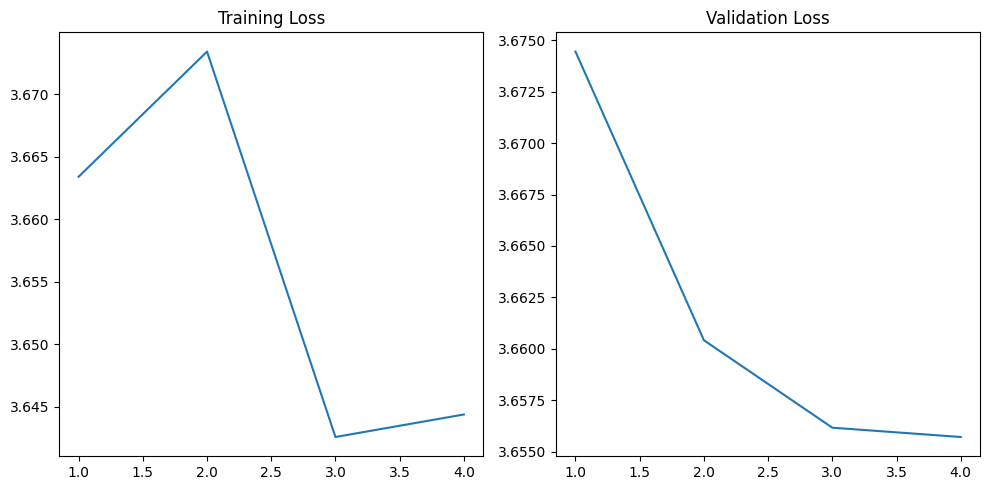

In [ ]:
import matplotlib.pyplot as plt

x1 = [1, 2, 3, 4]
y1 = [3.663400,3.673400,3.642600,3.644400]


x2 = [1, 2, 3, 4]
y2 = [3.674450,3.660413,3.656160,3.655707]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x1, y1)
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(x2, y2)
plt.title('Validation Loss')
plt.tight_layout()
plt.show()


In [ ]:
results = sft_trainer.evaluate()
print(results)

{'eval_loss': 3.6557071208953857, 'eval_runtime': 277.6066, 'eval_samples_per_second': 36.022, 'eval_steps_per_second': 4.503, 'epoch': 4.0}


In [ ]:
import numpy as np
def perplexity(eval_output):
    return np.exp(eval_output)

In [ ]:
perplexity(results['eval_loss'])

38.694873396859926

In [ ]:
del sft_trainer, tokenizer
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)

In [ ]:
prompt="I good in football but"
inputs=tokenizer(prompt, return_tensors="pt")

In [ ]:
outputs=peft_model.generate(**inputs)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1355: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1636: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [ ]:
tokenizer.batch_decode(outputs, skip_special_token=True)

["I good in football but I don't like the game. I like the game but I don't like the"]